# 傾向スコア

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

import xarray as xr
from patsy import dmatrix

In [2]:
filepath = "../../../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df = df.dropna()

In [11]:
population = df['population']
bridge = df['dummy_after_bridge_opened']
income = df['income']
log_income = np.log(income)
area = df['area_km2']
log_area = np.log(area)
distance = df['distance_m']
log_distance = np.log(distance)
density = population / area

X = dmatrix('log_income + log_area + log_distance + density -1', data=df, return_type='dataframe')
year = dmatrix('C(year)', data=df, return_type='dataframe')

In [5]:
X.shape, year.shape

((901, 4), (901, 8))

In [13]:
with pm.Model() as model:
    # prior
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100, shape=X.shape[1], dims='X')
    tau = pm.Normal('tau', mu=0, sigma=100, shape=year.shape[1], dims='year')

    # link function
    p = pm.math.sigmoid(alpha + pm.math.dot(X, beta) + pm.math.dot(year, tau))

    # likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=bridge)

graph = pm.model_to_graphviz(model)
display(graph)

RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
with model:
    idata = pm.sample(
        draws=3000,
        tune=10000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )


  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packag

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.373,0.720,-0.925,0.845,0.360,0.275,4.0,4.0,NaN
beta[1],0.254,0.606,-0.497,0.991,0.303,0.232,4.0,4.0,NaN
beta[2],0.217,0.306,-0.277,0.561,0.153,0.117,4.0,4.0,NaN
beta[3],-0.135,0.564,-0.740,0.765,0.281,0.216,4.0,4.0,NaN
beta[4],-0.283,0.323,-0.691,0.134,0.161,0.124,4.0,4.0,NaN
beta[5],-0.020,0.332,-0.398,0.497,0.166,0.127,4.0,4.0,NaN
gamma[0],0.110,0.449,-0.424,0.590,0.224,0.172,4.0,4.0,NaN
gamma[1],-0.240,0.239,-0.492,0.115,0.120,0.092,4.0,4.0,NaN
gamma[2],0.182,0.778,-0.853,0.984,0.388,0.297,4.0,4.0,NaN
gamma[3],-0.357,0.602,-0.905,0.650,0.301,0.230,4.0,4.0,NaN


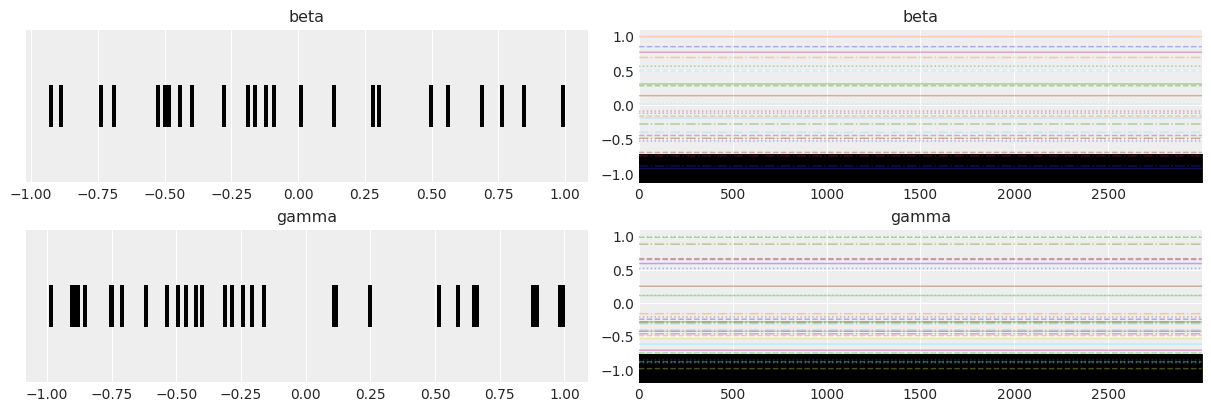

In [22]:
az.plot_trace(idata)  # サイズを調整
az.summary(idata)